In [1]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news
!unzip sentiment-analysis-for-financial-news.zip -d .

  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 143MB/s]
Archive:  sentiment-analysis-for-financial-news.zip
  inflating: ./FinancialPhraseBank/License.txt  
  inflating: ./FinancialPhraseBank/README.txt  
  inflating: ./FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: ./FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: ./FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: ./FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: ./all-data.csv          


In [2]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d .

--2023-04-28 10:48:49--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-28 10:48:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-04-28 10:51:28 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: ./glove.6B.50d.txt      
  inflating: ./glove.6B.100d.txt     
  inflatin

In [3]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [5]:
embed_size = 300
glove = defaultdict()
with open("glove.6B."+(str)(embed_size)+"d.txt", "r") as f:
  for line in f.readlines():
    l = line.split()
    glove[l[0]] = np.array([(float)(x) for x in l[1:]]+[1]) # 1 is for bias

In [6]:
def softmax(x):
  return np.exp(x)/(np.sum(np.exp(x), axis=-1).repeat(x.shape[-1], axis=-1).reshape(x.shape))

def loss(y_true, y_pred):
  return np.mean(np.sum(-y_true*np.log(y_pred),axis=-1))

def accuracy(y_true, y_pred):
  return sum([(int)(p) for p in np.argmax(y_pred, axis=-1) == np.argmax(y_true, axis=-1)])/len(y_true)

class logisticmodel():
  def __init__(self, n_features, n_categories):
    self.W = np.random.random((n_categories, n_features+1))
    
  def forward(self, X):
    self.X = X
    self.pred = softmax((X@self.W.T))
    return self.pred
  def backpropagate(self, y_true, lr):
    self.W = self.W - lr * (self.pred - y_true).T@self.X
  def train(self, X, y, X_val, y_val, batch_size, epochs, lr):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc":[]}
    for i in range(epochs):
      for b in range((int)(len(X)/batch_size)):
        pred = self.forward(X[b*batch_size:min((b+1)*batch_size, len(X))])
        self.backpropagate(y[b*batch_size:min((b+1)*batch_size, len(X))], lr)
      if X_val:
        pred = self.forward(X_val)
        history["val_loss"].append(loss(y_val, pred))
        history["val_acc"].append(accuracy(y_val, pred))
      pred = self.forward(X)
      history["train_loss"].append(loss(y, pred))
      history["train_acc"].append(accuracy(y, pred))
      
      if (i+1)%100 == 0 or i == 0:
        if X_val:
          print("epoch {:4} loss is: {:.3f} - accuracy is: {:.3f} - val_loss is: {:.3f} - val_acc is: {:.3f}".format(i+1, history["train_loss"][-1], history["train_acc"][-1]*100, history["val_loss"][-1], history["val_acc"][-1]*100))
        else:
          print("epoch {:4} loss is: {:.3f} - accuracy is: {:.3f}".format(i+1, history["train_loss"][-1], history["train_acc"][-1]*100))
    return history
  def test(self, X, y):
    pred = self.forward(X)
    print("========================================================")
    print("                     Test Report                        ")
    print("========================================================")
    print(classification_report(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1)))



In [7]:
data= pd.read_csv("all-data.csv",  on_bad_lines="skip", encoding="ISO-8859-1", header=None)


X_train, X_test, y_train, y_test = train_test_split(data[1], data[0], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

onehot = OneHotEncoder()
onehot.fit(np.array(y_train).reshape(-1,1))
y_train = onehot.transform(np.array(y_train).reshape(-1,1)).toarray()
y_val = onehot.transform(np.array(y_val).reshape(-1,1)).toarray()
y_test = onehot.transform(np.array(y_test).reshape(-1,1)).toarray()

data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
def sentence2vec(sentence):
  vec = []
  stop = nltk.corpus.stopwords.words('english')
  for w in word_tokenize(sentence.lower()):
    v = glove.get(w, glove.get('unk'))
    # if np.array_equal(v ,glove.get('unk')):
    #   continue
    vec.append(v)
  vec = np.array(vec)
  return np.mean(vec, axis=0)

In [9]:
X_train = [sentence2vec(x) for x in X_train]
X_val = [sentence2vec(x) for x in X_val]
X_test = [sentence2vec(x) for x in X_test]

epoch    1 loss is: 0.955 - accuracy is: 56.116 - val_loss is: 0.973 - val_acc is: 51.487
epoch  100 loss is: 0.676 - accuracy is: 70.821 - val_loss is: 0.690 - val_acc is: 71.167
epoch  200 loss is: 0.629 - accuracy is: 73.420 - val_loss is: 0.655 - val_acc is: 72.540
epoch  300 loss is: 0.604 - accuracy is: 74.388 - val_loss is: 0.641 - val_acc is: 72.311
epoch  400 loss is: 0.589 - accuracy is: 75.586 - val_loss is: 0.634 - val_acc is: 72.540
epoch  500 loss is: 0.578 - accuracy is: 75.790 - val_loss is: 0.630 - val_acc is: 71.625
epoch  600 loss is: 0.569 - accuracy is: 76.376 - val_loss is: 0.627 - val_acc is: 71.854
epoch  700 loss is: 0.562 - accuracy is: 76.631 - val_loss is: 0.625 - val_acc is: 71.854
epoch  800 loss is: 0.557 - accuracy is: 76.911 - val_loss is: 0.624 - val_acc is: 71.625
epoch  900 loss is: 0.553 - accuracy is: 76.758 - val_loss is: 0.623 - val_acc is: 72.082
epoch 1000 loss is: 0.549 - accuracy is: 77.013 - val_loss is: 0.622 - val_acc is: 72.769
epoch 1100

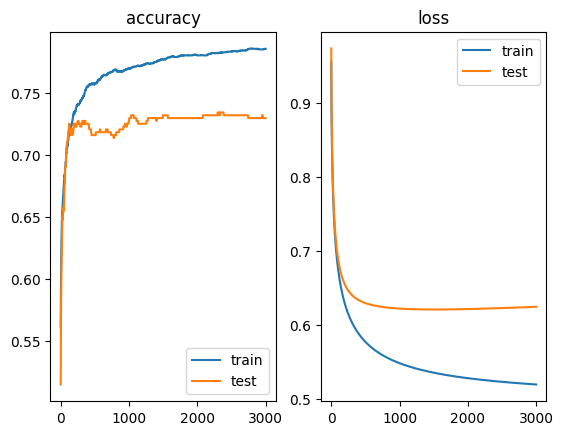

                     Test Report                        
              precision    recall  f1-score   support

           0       0.64      0.52      0.57        62
           1       0.74      0.82      0.78       283
           2       0.58      0.51      0.54       140

    accuracy                           0.69       485
   macro avg       0.65      0.61      0.63       485
weighted avg       0.68      0.69      0.68       485



In [10]:
batch_size = 64
categories = 3
epochs = 3000
lr = 5e-4

model = logisticmodel(embed_size, categories)
history = model.train(X_train, y_train, X_val, y_val, batch_size, epochs, lr)
fig, ax = plt.subplots(ncols=2)
ax[0].plot(history["train_acc"], label="train")
ax[0].plot(history["val_acc"], label="test")
ax[0].legend()
ax[0].set_title("accuracy")
ax[1].plot(history["train_loss"], label="train")
ax[1].plot(history["val_loss"], label="test")
ax[1].legend()
ax[1].set_title("loss")
plt.show()
model.test(X_test, y_test)

In [11]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, [np.argmax(y) for y in y_train])
print(classification_report(np.argmax(y_test, axis=-1), clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.29      0.47      0.36        62
           1       0.70      0.84      0.76       283
           2       0.43      0.14      0.21       140

    accuracy                           0.59       485
   macro avg       0.47      0.48      0.44       485
weighted avg       0.57      0.59      0.55       485

